In [55]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import sqlite3

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, show
import matplotlib.style as style

import os
print(os.listdir("../input"))

style.use('seaborn-poster') #sets the size of the charts
style.use('fivethirtyeight')
# Any results you write to the current directory are saved as output.

['database.sqlite']


In [37]:
database = '../input/database.sqlite'
conn = sqlite3.connect(database)

# we have a db with tables
query = "SELECT name FROM sqlite_master WHERE type='table';"
pd.read_sql(query, conn) # here we show the tables avaiable

,name
0,sqlite_sequence
1,Player_Attributes
2,Player
3,Match
4,League
5,Country
6,Team
7,Team_Attributes


In [72]:
query = "SELECT * FROM Match;"
matches = pd.read_sql(query, conn)
matches.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_X1,home_player_X2,home_player_X3,home_player_X4,home_player_X5,home_player_X6,home_player_X7,home_player_X8,home_player_X9,home_player_X10,home_player_X11,away_player_X1,away_player_X2,away_player_X3,away_player_X4,away_player_X5,away_player_X6,away_player_X7,away_player_X8,away_player_X9,away_player_X10,away_player_X11,home_player_Y1,home_player_Y2,home_player_Y3,home_player_Y4,home_player_Y5,home_player_Y6,home_player_Y7,...,away_player_10,away_player_11,goal,shoton,shotoff,foulcommit,card,cross,corner,possession,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,LBD,LBA,PSH,PSD,PSA,WHH,WHD,WHA,SJH,SJD,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,None,None,None,None,None,None,None,None,1.73,3.40,5.00,1.75,3.35,4.20,1.85,3.2,3.5,1.80,3.3,3.75,NaN,NaN,NaN,1.70,3.30,4.33,1.90,3.3,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,None,None,None,None,None,None,None,None,1.95,3.20,3.60,1.80,3.30,3.95,1.90,3.2,3.5,1.90,3.2,3.50,NaN,NaN,NaN,1.83,3.30,3.60,1.95,3.3,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,None,None,None,None,None,None,None,None,2.38,3.30,2.75,2.40,3.30,2.55,2.60,3.1,2.3,2.50,3.2,2.50,NaN,NaN,NaN,2.50,3.25,2.40,2.63,3.3,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,None,None,None,None,None,None,None,None,1.44,3.75,7.50,1.40,4.00,6.80,1.40,3.9,6.0,1.44,3.6,6.50,NaN,NaN,NaN,1.44,3.75,6.00,1.44,4.0,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,None,None,None,None,None,None,None,None,5.00,3.50,1.65,5.00,3.50,1.60,4.00,3.3,1.7,4.00,3.4,1.72,NaN,NaN,NaN,4.20,3.40,1.70,4.50,3.5,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67


In [85]:
max_home_goal = matches.home_team_goal.max()
max_away_goal = matches.away_team_goal.max()

print("Scores with max number of goal for home team:\n",
      matches[['home_team_goal', "away_team_goal"]][matches.home_team_goal == max_home_goal])

print("\nScores with max number of goal for away team:\n",
      matches[['home_team_goal', "away_team_goal"]][matches.away_team_goal == max_away_goal])

Scores with max number of goal for home team:
        home_team_goal  away_team_goal
13898              10               0
24247              10               2

Scores with max number of goal for away team:
       home_team_goal  away_team_goal
7660               0               9


In [38]:
query = "SELECT * FROM Player;" # sql query to access the Player table
players = pd.read_sql(query, conn)
players.head()
# not much info here..

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187
1,2,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146
2,3,162549,Aaron Doran,186170,1991-05-13 00:00:00,170.18,163
3,4,30572,Aaron Galindo,140161,1982-05-08 00:00:00,182.88,198
4,5,23780,Aaron Hughes,17725,1979-11-08 00:00:00,182.88,154


In [39]:
query = "SELECT * FROM Team;" # sql query to access the table
team = pd.read_sql(query, conn)
team.head()
# I'd like to extract from each player the team where they play, is it possible?

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.0,KRC Genk,GEN
1,2,9993,675.0,Beerschot AC,BAC
2,3,10000,15005.0,SV Zulte-Waregem,ZUL
3,4,9994,2007.0,Sporting Lokeren,LOK
4,5,9984,1750.0,KSV Cercle Brugge,CEB


In [40]:
query = "SELECT * FROM Team_Attributes;"
team_att = pd.read_sql(query, conn)
team_att.head()

,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,buildUpPlayPositioningClass,chanceCreationPassing,chanceCreationPassingClass,chanceCreationCrossing,chanceCreationCrossingClass,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,1,434,9930,2010-02-22 00:00:00,60,Balanced,NaN,Little,50,Mixed,Organised,60,Normal,65,Normal,55,Normal,Organised,50,Medium,55,Press,45,Normal,Cover
1,2,434,9930,2014-09-19 00:00:00,52,Balanced,48.0,Normal,56,Mixed,Organised,54,Normal,63,Normal,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
2,3,434,9930,2015-09-10 00:00:00,47,Balanced,41.0,Normal,54,Mixed,Organised,54,Normal,63,Normal,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
3,4,77,8485,2010-02-22 00:00:00,70,Fast,NaN,Little,70,Long,Organised,70,Risky,70,Lots,70,Lots,Organised,60,Medium,70,Double,70,Wide,Cover
4,5,77,8485,2011-02-22 00:00:00,47,Balanced,NaN,Little,52,Mixed,Organised,53,Normal,48,Normal,52,Normal,Organised,47,Medium,47,Press,52,Normal,Cover


In [41]:
query = "SELECT * FROM League;"
league = pd.read_sql(query, conn)
league.head()

,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League
2,4769,4769,France Ligue 1
3,7809,7809,Germany 1. Bundesliga
4,10257,10257,Italy Serie A


In [42]:
query = "SELECT * FROM Country;"
country = pd.read_sql(query, conn)
country.head()

,id,name
0,1,Belgium
1,1729,England
2,4769,France
3,7809,Germany
4,10257,Italy


In [43]:
query = "SELECT * FROM Player_Attributes;" # sql query to access the Player table
players_att = pd.read_sql(query, conn)
players_att.head()
# here we have more information for each player. This is huge
# looks like the foreign key we need to refer to is 'player_api_id'
# here we have multiple entries per each player, because each attribute was recorded in different dates. Need more info.

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,63.0,41.0,45.0,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,63.0,48.0,60.0,64.0,59.0,46.0,65.0,54.0,58.0,54.0,76.0,34.0,62.0,40.0,44.0,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,63.0,48.0,60.0,64.0,59.0,46.0,65.0,54.0,58.0,54.0,76.0,34.0,62.0,40.0,44.0,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [44]:
# could we average all this info by player? Just to have a summary of each players stats, then merge with players df
players_stat = players_att.copy()
players_stat = players_stat.drop(['player_fifa_api_id', 'date', 'id'], axis=1)
players_stat = players_stat.groupby('player_api_id', as_index=False).mean()
players_stat.head()
# here now we have a summary of each player stats

,player_api_id,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,2625,60.142857,61.142857,50.142857,47.285714,46.285714,56.500000,38.000000,54.142857,50.000000,49.928571,65.571429,59.142857,66.857143,63.285714,66.428571,49.714286,66.214286,66.714286,58.714286,77.285714,55.785714,56.857143,71.285714,62.071429,50.357143,55.285714,61.928571,62.928571,63.857143,56.571429,12.428571,12.857143,19.071429,10.357143,10.428571
1,2752,69.380952,70.380952,36.428571,37.428571,75.333333,54.809524,20.428571,44.857143,30.428571,18.857143,59.571429,55.571429,41.619048,42.190476,43.333333,60.857143,44.571429,57.428571,56.523810,60.904762,82.238095,19.571429,80.285714,71.428571,31.428571,52.428571,35.428571,71.095238,70.666667,65.571429,11.095238,6.095238,7.095238,9.095238,15.095238
2,2768,69.285714,70.571429,42.238095,42.761905,66.666667,64.714286,28.761905,40.238095,51.761905,20.047619,57.000000,56.380952,56.952381,58.904762,58.047619,69.809524,60.190476,38.761905,76.904762,59.285714,67.428571,19.428571,62.761905,74.714286,44.190476,57.761905,31.904762,71.666667,70.619048,79.714286,10.761905,15.904762,22.714286,15.142857,12.095238
3,2770,71.133333,73.533333,61.866667,67.666667,67.800000,72.533333,67.133333,75.066667,79.800000,68.666667,70.266667,76.733333,62.200000,59.800000,62.600000,65.933333,61.266667,68.333333,57.133333,51.000000,62.600000,73.000000,56.800000,44.933333,64.533333,71.600000,63.933333,30.200000,37.533333,25.000000,8.666667,15.666667,27.200000,16.333333,17.000000
4,2790,70.200000,75.800000,70.000000,37.400000,55.200000,68.000000,43.000000,60.800000,67.000000,55.400000,69.800000,66.800000,70.800000,71.200000,65.000000,69.200000,67.000000,46.400000,61.000000,70.400000,71.000000,42.400000,68.400000,63.400000,60.600000,60.000000,55.400000,74.600000,74.600000,69.000000,8.000000,17.000000,59.000000,16.600000,17.400000


In [45]:
# lets look into a merge for players and players_stat, by player_api_id
print("Players shape:", players.shape)
print("Players Stats shape:", players_stat.shape)
# here we can see that we have the same number of rows for both df.
# correct number of players

Players shape: (11060, 7)
Players Stats shape: (11060, 36)


In [46]:
players_merged = pd.merge(players, players_stat, on='player_api_id')
players_merged.head()
# this is the final table that describes each player characteristics

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187,63.600000,67.600000,48.600000,43.600000,70.600000,60.600000,43.600000,50.600000,44.600000,38.600000,63.600000,48.600000,60.000000,64.000000,59.000000,46.600000,65.000000,54.600000,58.000000,54.000000,76.000000,34.600000,65.800000,52.200000,44.600000,53.600000,47.600000,63.800000,66.000000,67.800000,5.600000,10.600000,9.600000,7.600000,7.600000
1,2,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146,66.969697,74.484848,70.787879,49.454545,52.939394,62.272727,29.151515,61.090909,61.878788,62.121212,63.242424,61.787879,76.000000,74.939394,75.242424,67.848485,84.727273,65.909091,75.303030,72.878788,51.757576,54.121212,65.060606,57.878788,51.484848,57.454545,53.121212,69.393939,68.787879,71.515152,12.181818,8.666667,14.242424,10.363636,12.909091
2,3,162549,Aaron Doran,186170,1991-05-13 00:00:00,170.18,163,67.000000,74.192308,68.115385,57.923077,58.692308,65.115385,54.269231,69.038462,60.192308,55.615385,60.461538,68.615385,75.538462,77.500000,77.615385,50.346154,80.730769,62.807692,67.307692,70.923077,70.076923,58.038462,59.115385,47.269231,61.807692,69.384615,60.538462,22.038462,21.115385,21.346154,14.038462,11.807692,17.730769,10.115385,13.500000
3,4,30572,Aaron Galindo,140161,1982-05-08 00:00:00,182.88,198,69.086957,70.782609,57.217391,26.260870,69.260870,64.695652,47.782609,55.565217,37.782609,40.391304,60.826087,63.173913,50.217391,52.826087,62.826087,58.217391,44.086957,64.869565,70.782609,55.434783,78.695652,31.304348,69.304348,61.565217,35.913043,53.782609,41.739130,70.608696,70.652174,68.043478,14.173913,11.173913,22.869565,11.173913,10.173913
4,5,23780,Aaron Hughes,17725,1979-11-08 00:00:00,182.88,154,73.240000,74.680000,45.080000,38.840000,73.040000,64.760000,32.080000,50.600000,45.480000,26.360000,56.840000,60.160000,51.120000,54.080000,50.760000,69.400000,64.160000,47.080000,77.840000,66.480000,73.800000,24.280000,69.680000,76.840000,40.080000,46.480000,52.960000,77.600000,76.040000,74.600000,8.280000,8.320000,24.920000,12.840000,11.920000


In [47]:
# fix dates
players_merged['birthday'] = pd.to_datetime(players_merged['birthday'])
players_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11060 entries, 0 to 11059
Data columns (total 42 columns):
id                    11060 non-null int64
player_api_id         11060 non-null int64
player_name           11060 non-null object
player_fifa_api_id    11060 non-null int64
birthday              11060 non-null datetime64[ns]
height                11060 non-null float64
weight                11060 non-null int64
overall_rating        11060 non-null float64
potential             11060 non-null float64
crossing              11060 non-null float64
finishing             11060 non-null float64
heading_accuracy      11060 non-null float64
short_passing         11060 non-null float64
volleys               10582 non-null float64
dribbling             11060 non-null float64
curve                 10582 non-null float64
free_kick_accuracy    11060 non-null float64
long_passing          11060 non-null float64
ball_control          11060 non-null float64
acceleration          11060 non-null f

In [58]:
# extract the year from each birth date
def year_ext(x):
    return x.year
players_merged['year_birth'] = players_merged['birthday'].apply(year_ext)

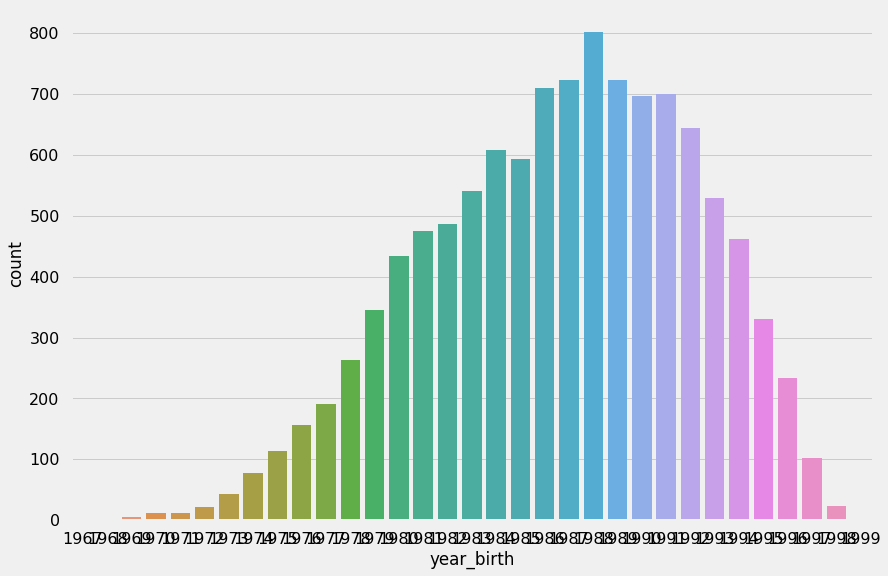

In [61]:
#plt.figure(figsize=(20,15))
sns.countplot(x='year_birth', data=players_merged)

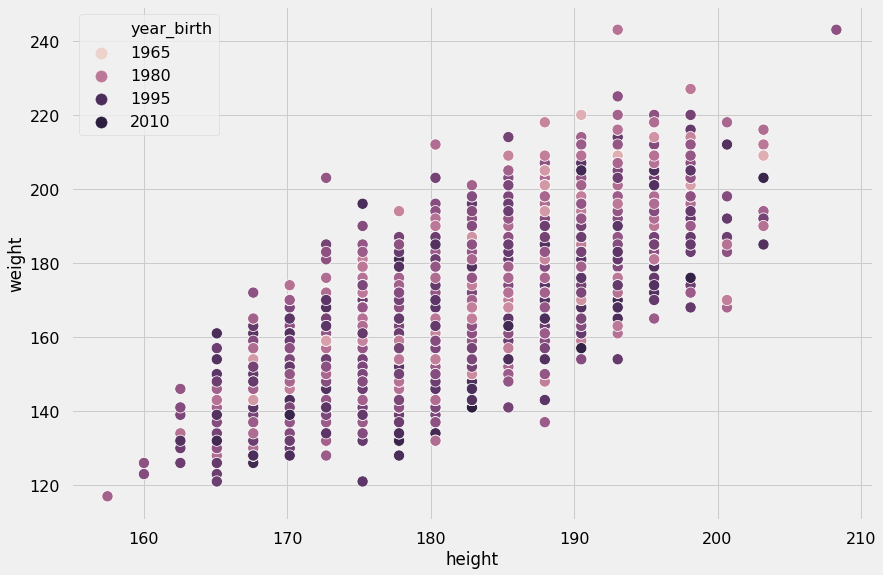

In [50]:
sns.scatterplot(x='height', y='weight', hue='year_birth', data=players_merged)

In [51]:
# top 10 player by overall rating
players_merged.sort_values('overall_rating', ascending=False).head(10)

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,year_birth
6169,6176,30981,Lionel Messi,158023,1987-06-24,170.18,159,92.192308,95.230769,83.346154,92.230769,69.269231,88.807692,87.538462,96.461538,87.692308,84.115385,76.615385,95.769231,95.307692,90.846154,94.384615,92.538462,92.230769,80.307692,69.653846,77.538462,59.692308,86.923077,49.269231,34.230769,90.538462,90.269231,80.153846,18.769231,21.846154,20.115385,6.461538,12.653846,29.461538,15.076923,10.615385,1987
1992,1995,30893,Cristiano Ronaldo,20801,1985-02-05,185.42,176,91.280000,93.480000,83.880000,91.120000,85.520000,82.280000,85.560000,92.640000,88.000000,81.640000,71.720000,93.960000,91.640000,93.760000,92.960000,88.160000,74.320000,92.760000,93.040000,87.600000,78.680000,89.880000,61.280000,35.640000,86.480000,80.680000,83.600000,22.120000,30.840000,23.000000,7.480000,12.960000,28.440000,15.160000,12.760000,1985
3510,3514,30924,Franck Ribery,156616,1983-04-07,170.18,159,88.458333,89.916667,85.166667,77.750000,48.541667,87.791667,82.041667,92.916667,86.833333,81.750000,73.500000,91.458333,91.916667,89.666667,91.583333,86.041667,89.291667,75.333333,54.291667,74.166667,63.833333,74.750000,59.166667,46.125000,84.041667,86.958333,81.500000,18.708333,25.083333,26.000000,13.333333,8.541667,22.833333,9.500000,11.708333,1983
739,742,30955,Andres Iniesta,41,1984-05-11,170.18,150,88.320000,90.560000,83.720000,72.680000,55.320000,93.880000,74.000000,90.080000,80.000000,69.280000,89.000000,92.960000,79.960000,76.800000,86.440000,89.320000,86.040000,66.840000,54.640000,77.720000,60.480000,76.160000,59.400000,72.360000,88.200000,92.920000,71.120000,58.240000,59.680000,56.000000,6.760000,14.720000,26.040000,14.520000,10.000000,1984
11041,11057,35724,Zlatan Ibrahimovic,41236,1981-10-03,195.58,209,88.285714,90.047619,72.380952,90.000000,79.714286,84.238095,90.047619,89.380952,80.952381,81.380952,66.761905,91.238095,76.285714,80.000000,82.285714,82.666667,60.476190,91.761905,76.380952,75.714286,90.571429,86.523810,79.666667,38.714286,83.095238,82.619048,88.000000,20.904762,43.809524,26.809524,12.666667,17.142857,24.714286,13.238095,15.142857,1981
948,951,30834,Arjen Robben,9014,1984-01-23,180.34,176,87.840000,88.600000,82.480000,82.160000,51.560000,84.520000,84.480000,92.640000,84.800000,83.120000,74.000000,89.520000,92.400000,91.320000,91.680000,86.640000,87.160000,82.000000,59.400000,71.640000,62.640000,86.440000,41.920000,45.800000,85.600000,82.400000,81.480000,26.240000,24.480000,25.240000,9.280000,10.680000,26.360000,8.760000,16.320000,1984
10845,10861,39854,Xavi Hernandez,10535,1980-01-25,170.18,148,87.636364,88.363636,86.090909,73.590909,54.727273,95.181818,67.545455,82.363636,84.363636,86.681818,91.727273,93.363636,70.545455,68.954545,83.090909,91.727273,87.454545,69.409091,53.636364,72.818182,62.045455,76.772727,55.545455,76.454545,86.954545,95.681818,78.227273,55.863636,64.545455,62.272727,5.727273,16.136364,30.227273,8.363636,11.409091,1980
10733,10749,30829,Wayne Rooney,54050,1985-10-24,175.26,183,87.222222,87.944444,78.472222,87.861111,78.583333,83.138889,88.694444,82.694444,83.500000,79.861111,83.416667,86.583333,77.416667,79.361111,78.472222,86.416667,78.777778,90.277778,79.916667,88.000000,86.166667,85.361111,90.388889,48.611111,87.166667,84.166667,82.333333,30.750000,51.833333,37.777778,10.138889,12.000000,21.861111,9.527778,8.694444,1985
4362,4366,30657,Iker Casillas,5479,1981-05-20,185.42,185,86.954545,88.227273,16.136364,14.454545,19.454545,21.000000,13.136364,19.590909,16.727273,16.681818,35.954545,25.500000,66.272727,63.181818,62.590909,82.909091,46.

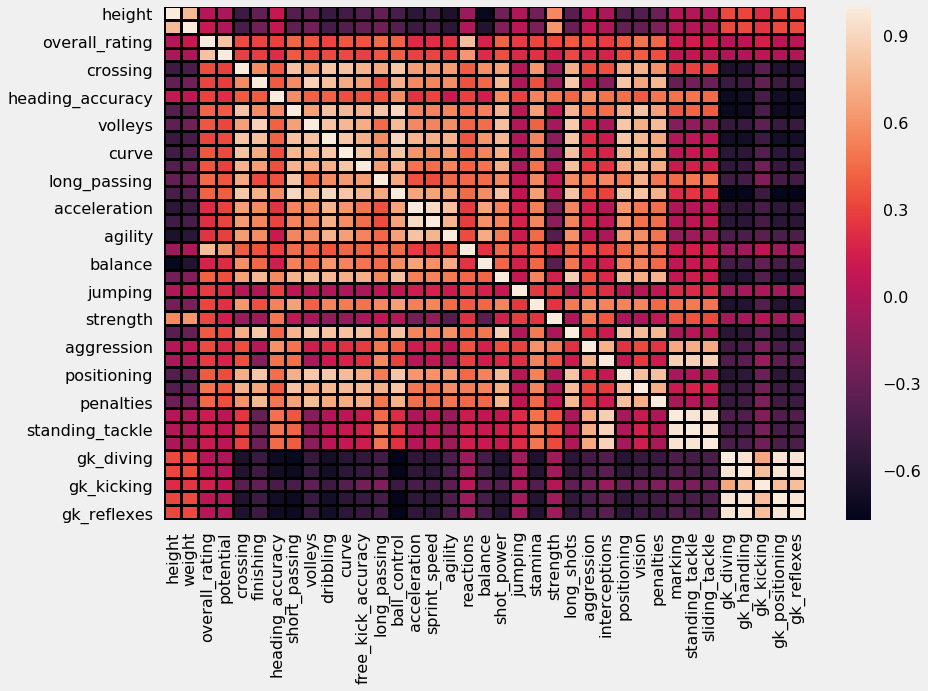

In [68]:
# correlation between players stats
#correlation = player.corr()
#sns.heatmap(correlation,annot=True,fmt="f",linecolor="k",
#            linewidths=2,cmap =sns.color_palette("Set2"))
#plt.title("CORRELATION BETWEEN VARIABLES")
#plt.show()

correlations = players_merged.drop(['id', 'player_api_id', 'player_name', 'player_fifa_api_id', 'birthday', 'year_birth'], 
                                   axis=1).corr()
sns.heatmap(correlations, fmt='f', linecolor='k', linewidths=2)
plt.show()
# this plot is huge, but has lots of possible infos
# not surprising gk_* stats are negativly correlated with some features which are typical of other roles. 